<a href="https://colab.research.google.com/github/llA-Wilsonll/Simpsons_Character_Recognition/blob/master/The_Simpsons_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In the previous notebook, I built (simple) models from scratch to try and classify images of 14 differnt simpsons characters. Due to the small dataset and the resources I have available to me to train the model, it wasn't feasible to train a super complex model to classify these images.

Thankfully, there are many publicly available models which have been trained on much more data for much longer than we ever could. We can piggy-back off these models using their weights to extract features from our own images. To do so we will download a model and freeze it's layers up to a certain point, after which we will add some of our own dense layer which we will train.

In this notebook I will adapt my learnings on Transfer Learning from the Coursera Tensorflow course and apply it to my Simpsons Character recognition task.

# Set up
Loading the required packages

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
import re
import itertools
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from sklearn.metrics import classification_report, confusion_matrix

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile 
import os
import random

Loading our dataset we saved to Google Drive in an earlier notebook

In [3]:
# Insert your file ID below
# An example : https://drive.google.com/file/d/1iz5JmTB4YcBvO7amj3Sy2_scSeAsN4gd/view?usp=sharing
zip_id = '1HGcEPmGBYAXIp4TUdiIlYodBdHZswNYB'

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('/content/simpsons_generator_v2'):
    os.makedirs('/content/simpsons_generator_v2')

# 2. Download Zip
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('simpsons_generator_directory_v2.zip')

# 3. Unzip
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('simpsons_generator_directory_v2.zip', 'r')
zip_ref.extractall('/content/simpsons_generator_v2/')
zip_ref.close()

Uncompressing zip file


In [0]:
# Saving the location of our base directory as a variable
base_dir = '/content/simpsons_generator_v2/simpsons_generator_directory_edit/'

# Define the Model


In [5]:
# Defining the InceptionV3 model using weights from being trained on ImageNet
pre_trained_model = InceptionV3(input_shape = (128, 128, 3), 
                                include_top = False, 
                                weights = 'imagenet')

# Freezing the weights of the model
for layer in pre_trained_model.layers:
  layer.trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
87916544/87910968 [==============================] - 1s 0us/step


In [6]:
# Print a summary of the model  
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

Below we choose what layer from the InceptionV3 model we want to use as the "output layer" which we will then feed into a dense layer before applying softmax classification.

Initially, I just chose the last layer of the InceptionV3 model (i.e. mixed10) through simply setting `output_layer` below to be `pre_trained_model.output`. However, this resulted in training starting off with 22.7% accuracy on the first epoch, and only reaching 44.8% accuracy by epoch 9.

Based on learnings from the Tensorflow course in Coursera, I decided to set the last layer to be mixed7 instead of mixed 10. Doing so resulted in the model reaching an accuracy of 81.8% by epoch 9 (with a validation accuracy of only 43%). Thus, it did indeed improve model training, however it still couldn't compare the relatively simple model I built in the `The_Simpsons_Building_Model` notebook.

I then decided to add a Conv2D layer before my dense layer to try and learn a better representation. I did this by adding `layers.Conv2D(128, (3, 3), padding = 'same', activation='relu')(output_layer)`. This resulted in achieving an accuracy of 86.2% by epoch 9 (with a validation accuracy of 51.4%) as seen below. I then continued to train the model for 60 epochs to see where we could get.

In [11]:
# Our output layer we want from InceptionV3 model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
output_layer = last_layer.output

last layer output shape:  (None, 6, 6, 768)


In [0]:
# Adding one more conv layer with same padding (input-output has same length)
x = layers.Conv2D(128, (3, 3), padding = 'same', activation='relu')(output_layer)

# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
                  
# Add a final softmax layer for classification of our characters
num_characters = len(os.listdir(base_dir + 'training'))
x = layers.Dense(num_characters, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer=Adam(), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [26]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

# Incorporate image augmentation and callback
We use the below code to allow us to perform a series of random transformations to each image before it is passed through our model, with the goal being to improve the generalisation of our model as it is seeing slightly different data to what it has seen in the previous epochs.

In [28]:
TRAINING_DIR = base_dir + 'training/'
train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                  rotation_range = 10,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=[0.9, 1.15])
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(128, 128))

VALIDATION_DIR = base_dir + 'validation/'
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='categorical',
                                                              target_size=(128, 128))

Found 15717 images belonging to 14 classes.
Found 1761 images belonging to 14 classes.


We will also use the below callback so that we can set our model to run for a large amount of epochs, but stop training once we reach our desired accuracy threshold, which we will set as 99%.

In [0]:
# Define the accuracy threshold we want to use
ACCURACY_THRESHOLD = 0.99

# Implement the callback class which stops training once accuracy reaches ACCURACY_THRESHOLD
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>ACCURACY_THRESHOLD):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

# Instantiate an object of myCallback class
callbacks = myCallback()

# Training the model

In [29]:
history = model.fit_generator(train_generator,
                              epochs=60,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks=[callbacks])

Epoch 1/60
158/158 [==============================] - 100s 630ms/step - loss: 1.7289 - acc: 0.4433 - val_loss: 5.5793 - val_acc: 0.3697
Epoch 2/60
158/158 [==============================] - 94s 595ms/step - loss: 0.8557 - acc: 0.7411 - val_loss: 6.3043 - val_acc: 0.3691
Epoch 3/60
158/158 [==============================] - 95s 598ms/step - loss: 0.7045 - acc: 0.7835 - val_loss: 5.6085 - val_acc: 0.4367
Epoch 4/60
158/158 [==============================] - 94s 592ms/step - loss: 0.6244 - acc: 0.8132 - val_loss: 6.2936 - val_acc: 0.4020
Epoch 5/60
158/158 [==============================] - 93s 588ms/step - loss: 0.5628 - acc: 0.8292 - val_loss: 4.0289 - val_acc: 0.5099
Epoch 6/60
158/158 [==============================] - 93s 590ms/step - loss: 0.5242 - acc: 0.8379 - val_loss: 4.3902 - val_acc: 0.4974
Epoch 7/60
158/158 [==============================] - 93s 587ms/step - loss: 0.5054 - acc: 0.8455 - val_loss: 4.7723 - val_acc: 0.4918
Epoch 8/60
158/158 [==============================] - 

# Saving the Model
I will save the model we have just trained so that we don't have to retrain the model again if we want to use it in a different session.

In [0]:
# Saving the model locally
model.save('/content/simpsons_transfer_learning_model.h5')

Saving this h5 file into Google Drive.

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Saving to GoogleDrive
file1 = drive.CreateFile()
file1.SetContentFile('simpsons_transfer_learning_model.h5')
file1.Upload()

# Analysing Model Performance
The below code plots how the loss and accuracy progressed on the both the training and validation set as the model was being trained.

Text(0.5, 1.0, 'Training and validation loss')

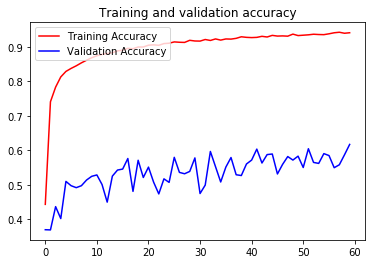

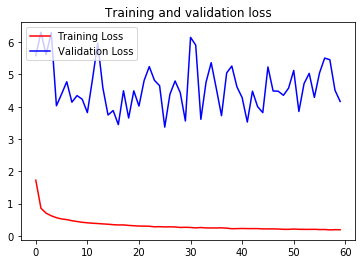

In [32]:
%matplotlib inline

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.legend(loc='upper left')


plt.title('Training and validation loss')

We can see from the above that our model was gradually learning to fit the training data well, but it was making very little progress in improving its predictions on examples it hadn't seen (the validation images).

We want to get a better sense of how our final model is performing on the validation data set. Thus, we define the below generator to allow us to look at the validation set more closely.

In [33]:
validation_test_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_test_generator = validation_test_datagen.flow_from_directory(
    directory = base_dir + 'validation/',
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 1761 images belonging to 14 classes.


Seeing how well our model performs with the validation set as its input.

In [0]:
test = model.evaluate_generator(generator=validation_test_generator,
                                steps=len(validation_test_generator))

In [35]:
# print(model.metrics_names)
print("The Validation Loss is:", test[1])

The Validation Loss is: 0.6172629


Thus, our model has an accuracy of **61.7%** on the validation set. This is noticeably worse than the 93.1% accuracy on the validation data set that the our model which we defined ourselves in the `The_Simpsons_Building_Model` notebook achieved.

To get a sense of on what characters our model is performing poorly, we will generate the below Classification Report and Confusion Matrix.

In [0]:
target_names = validation_test_generator.class_indices

# Using our model to make predictions on the validation_test_generator
Y_pred = model.predict_generator(generator=validation_test_generator, 
                                 steps=len(validation_test_generator))

# Returning the class with the highest prediction chance
y_pred = np.argmax(Y_pred, axis=1)

### Classification Report

In [37]:
print('Classification Report')
print(classification_report(validation_test_generator.classes, y_pred, target_names=target_names))

Classification Report
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.95      0.20      0.33        96
  apu_nahasapeemapetilon       0.95      0.53      0.68        70
            bart_simpson       0.56      0.80      0.66       135
charles_montgomery_burns       0.73      0.49      0.59       120
            chief_wiggum       0.70      0.43      0.53       105
           homer_simpson       0.66      0.74      0.70       225
        krusty_the_clown       0.65      0.77      0.71       121
            lisa_simpson       0.38      0.87      0.53       136
           marge_simpson       0.56      0.89      0.69       130
     milhouse_van_houten       0.51      0.83      0.63       115
             moe_szyslak       0.89      0.44      0.59       146
            ned_flanders       0.72      0.47      0.57       146
       principal_skinner       0.97      0.24      0.39       120
            sideshow_bob       1.00      0.72      0.

### Confusion Matrix

Confusion Matrix


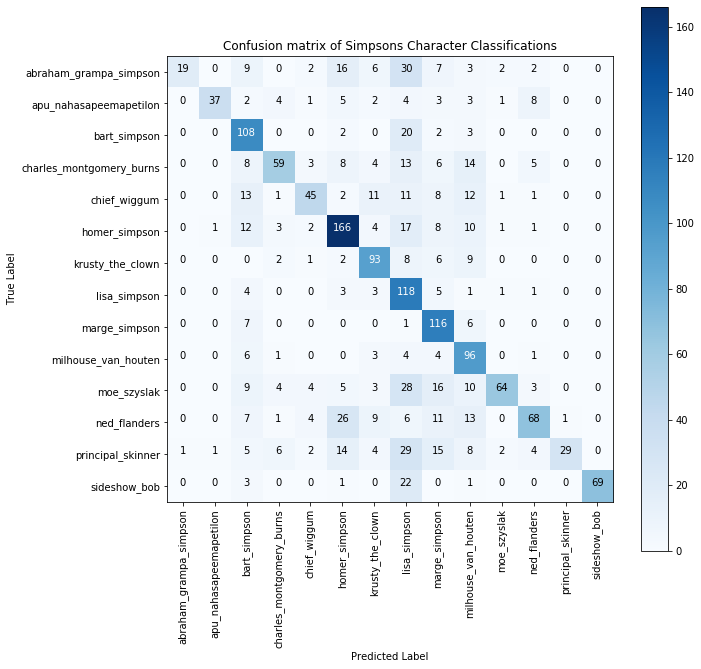

In [38]:
print('Confusion Matrix')
# Creating the confusion matrix as a Numpy array
conf_mtrx = confusion_matrix(validation_test_generator.classes, y_pred)

# Creating a Figure to plot the confusion matirx
fig = plt.figure(figsize = (10,10))
plt.imshow(conf_mtrx, interpolation='none', cmap=plt.cm.Blues)

# Title
plt.title('Confusion matrix of Simpsons Character Classifications')

# Adding a colour bar
plt.colorbar()

# Adding the character names to the X and Y axes
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=90)
plt.yticks(tick_marks, target_names)

# Adding labels to the X and Y axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Displaying the values for each entry in the confusion matrix
thresh = conf_mtrx.max() / 2.
for i, j in itertools.product(range(conf_mtrx.shape[0]), range(conf_mtrx.shape[1])):
    plt.text(j, i, conf_mtrx[i, j],
             horizontalalignment="center",
             color="white" if conf_mtrx[i, j] > thresh else "black")
    
# Running imshow again because the top and bottom of the plot seem to be
# getting cut off when this isnt run
plt.imshow(conf_mtrx, interpolation='none', cmap=plt.cm.Blues)

Thus, from the above Classification Report that our model has quite a high precision for some characters, meaning that if the model predicts an image is going to be of a certain character, such as Sideshow bob, Principal Skinner and Granpa Simpson, then it is very likely it will be correct.

The problem is that the recall for a lot of these characters is very bad, meaning that there are a lot of cases where the true image is of Grandpa Simpson for example and our model is predicting it will be of someone else. And if we look to the Confusion Matrix we can see that a lot of these cases are being predicted as Lisa. That is, our model seems to be biased towards predicting that a given image is of lisa.

Thus to summarise, our model seems to be incorrectly predicting a lot of images are of Lisa (and Marge and Milhouse), but when it does predict an image is of someone such as Granpda, Apu, Principal Skinner or Sideshow Bob then it is likely to be correct.